# Fuck MLP-Mixer

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
torch.backends.cudnn.enabled = False
import torchvision
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Dataset: CIFAR-10
transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(3)], [0.5 for _ in range(3)]
                            ),
    ]
)

trainset = torchvision.datasets.CIFAR10(root='./data/CIFAR-10', train=True, download=True, transform=transforms)
testset = torchvision.datasets.CIFAR10(root='./data/CIFAR-10', train=False, download=True, transform=transforms)

train_loader = DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


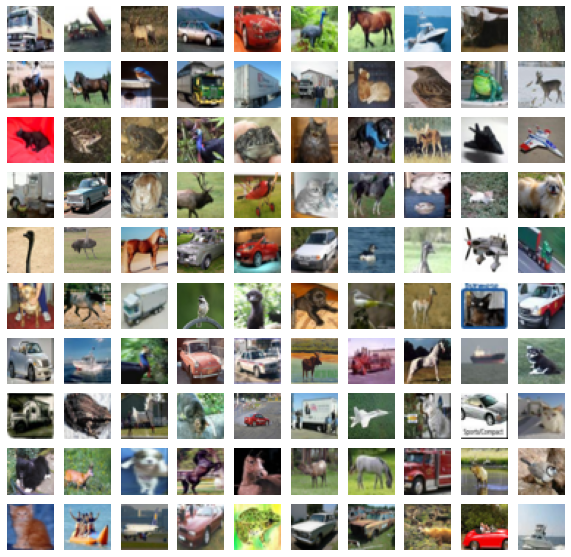

In [3]:
plt.figure(figsize=(10, 10))
for i in range(1, 101, 1):
  plt.subplot(10, 10, i)
  plt.imshow(trainset.data[i], cmap='gray')
  plt.axis('off')
plt.show()

## MLP-Mixer结构

<img src="assets/mlp_mixer.png"  width="600" />

In [18]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, embedding_dim, patch_size):
        super().__init__()
        self.patch_embedding = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.patch_embedding(x)
        return x

In [5]:
class MLP(nn.Module):
    def __init__(self, in_features, hidden_features, out_features, act_layer=nn.GELU, drop=0.):
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

注意一下两个转职T的原理：
* 第一次，只是将2/3维度进行交换，在Token Mixer之前使用
* 第二次，在patch编码后转置，从(batch_size, embedding_dim, sqrt(num_patches), sqrt(num_patches)) 到 (batch_size, num_patches, embedding_dim)


In [11]:
class Transpose1(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.permute(x, (0, 2, 1))

class Transpose2(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        return torch.permute(x, (0, 2, 3, 1)).reshape(x.shape[0], -1, x.shape[1])

In [12]:
class MixerLayer(nn.Module):
    def __init__(self, embedding_dim, num_patch, token_dim, channel_dim, dropout = 0.):
        super().__init__()
        
        self.token_mixer = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            Transpose1(),
            MLP(num_patch, token_dim, num_patch, drop=dropout),
            Transpose1(),
        )
        
        self.channel_mixer = nn.Sequential(
            nn.LayerNorm(embedding_dim),
            MLP(embedding_dim, channel_dim, embedding_dim, drop=dropout),
        )
        
    def forward(self, x):
        x = self.token_mixer(x) + x
        x = self.channel_mixer(x) + x
        return x

In [13]:
class MLPMixer(nn.Module):
    def __init__(self, 
                 in_channels,
                 embedding_dim, 
                 num_classes, 
                 patch_size, 
                 image_size, 
                 depth, 
                 token_dim, 
                 channel_dim):
        super(MLPMixer, self).__init__()
        self.num_patch =  int((image_size // patch_size) ** 2)
        self.patch_embedding = nn.Sequential(
            PatchEmbedding(in_channels, embedding_dim, patch_size),
            Transpose2(),
        )
        self.mixers = nn.ModuleList([
            MixerLayer(embedding_dim, self.num_patch, token_dim, channel_dim)
            for _ in range(depth)
        ])
        self.layer_norm = nn.LayerNorm(embedding_dim)
        self.fc = nn.Linear(embedding_dim, num_classes)
    
    def forward(self, x):
        x = self.patch_embedding(x)
        for mixer in self.mixers:
            x = mixer(x)
        x = self.layer_norm(x)
        x = x.mean(dim=1)
        x = self.fc(x)
        return x

In [19]:
X = torch.rand(64, 1, 28, 28) # a batch of 64 samples with 1 channel 28*28 images

pe = PatchEmbedding(1, 128, 4) # patch embedding layer
t1 = Transpose1()                       # switches dimension "2" and "3"
t2 = Transpose2()                       # flat the last 2 dimensions and switch dimension "2" and "3"
ml = MixerLayer(128, 49, 256, 256)

print("Input shape:                    ", X.shape)
y1 = pe(X)
print("Patch Embedding output shape:   ", y1.shape)
y2 = t2(y1)
print("T2 transformation output shape: ", y2.shape)
y3 = t1(y2)
print("T1 transformation output shape: ", y3.shape)
y4 = t1(y3)
print("T1 transformation output shape: ", y4.shape)
y5 = ml(y4)
print("Mixer Layer output shape:       ", y5.shape)

Input shape:                     torch.Size([64, 1, 28, 28])
Patch Embedding output shape:    torch.Size([64, 128, 7, 7])
T2 transformation output shape:  torch.Size([64, 49, 128])
T1 transformation output shape:  torch.Size([64, 128, 49])
T1 transformation output shape:  torch.Size([64, 49, 128])
Mixer Layer output shape:        torch.Size([64, 49, 128])


## 试着跑一下！

In [21]:
model = MLPMixer(in_channels=3, image_size=32, patch_size=2, num_classes=10,
                  embedding_dim=128, depth=4, token_dim=64, channel_dim=128).to("cuda")
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=4e-3)
num_epochs = 20
device = "cuda"

In [22]:
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
    for batch_index, (images, targets) in loop:
        images = images.to(device)
        targets = targets.to(device)
        logits = model(images)
        loss =  criterion(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # progress bar information updating
        loop.set_description(f"Epoch [{epoch+1}/{num_epochs}]")

In [23]:
def get_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            logits = model(x)
            _, predictions = logits.max(1)
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples


print(f"Accuracy on training set: {get_accuracy(train_loader, model)*100:.2f}")
print(f"Accuracy on test set: {get_accuracy(test_loader, model)*100:.2f}")

Accuracy on training set: 87.30
Accuracy on test set: 61.67
